# Spectral Embedding Methods

One of the primary embedding tools we'll use in this book is a set of methods called *spectral embedding* {cite:t}`spectraltutorial`. You'll see spectral embedding and variations on it repeatedly, both throughout this section and when we get into applications, so it's worth taking the time to understand spectral embedding deeply. If you're familiar with Principal Component Analysis (PCA), this method has a lot of similarities. We'll need to get into a bit of linear algebra to understand how it works.

Remember that the basic idea behind any network embedding method is to take the network and put it into Euclidean space - meaning, a nice data table with rows as observations and columns as features (or dimensions), which you can then plot on an x-y axis. In this section, you'll see the linear algebra-centric approach that spectral embedding uses to do this.

Spectral methods are based on a bit of linear algebra, but hopefully a small enough amount to still be understandable. The overall idea has to do with eigenvectors, and more generally, something called "singular vectors" - a generalization of eigenvectors. It turns out that the biggest singular vectors of a network's adjacency matrix contain the most information about that network - and as the singular vectors get smaller, they contain less information about the network (we're glossing over what 'information' means a bit here, so just think about this as a general intuition). So if you represent a network in terms of its singular vectors, you can drop the smaller ones and still retain most of the information. This is the essence of what spectral embedding is about (here "biggest" means "the singular vector corresponding to the largest singular value").

```{admonition} Singular Values and Singular Vectors
If you don't know what singular values and singular vectors are, don't worry about it. You can think of them as a generalization of eigenvalues/vectors (it's also ok if you don't know what those are): all matrices have singular values and singular vectors, but not all matrices have eigenvalues and eigenvectors. In the case of square, symmetric matrices with positive eigenvalues, the eigenvalues/vectors and singular values/vectors are the same thing.

If you want some more background information on eigenstuff and singularstuff, there are some explanations in the Math Refresher section in the introduction. They're an important set of vectors associated with matrices with a bunch of interesting properties. A lot of linear algebra is built around exploring those properties.
```

You can see visually how Spectral Embedding works below. We start with a 20-node Stochastic Block Model with two communities, and then found its singular values and vectors. It turns out that because there are only two communities, only the first two singular vectors contain information -- the rest are just noise! (you can see this if you look carefully at the first two columns of the eigenvector matrix). So, we took these two columns and scaled them by the first two singular vectors of the singular value matrix $D$. The final embedding is that scaled matrix, and the plot you see takes the rows of that matrix and puts them into Euclidean space (an x-y axis) as points. This matrix is called the *latent position matrix*, and the embeddings for the nodes are called the *latent positions*. Underneath the figure is a list that explains how the algorithm works, step-by-step.

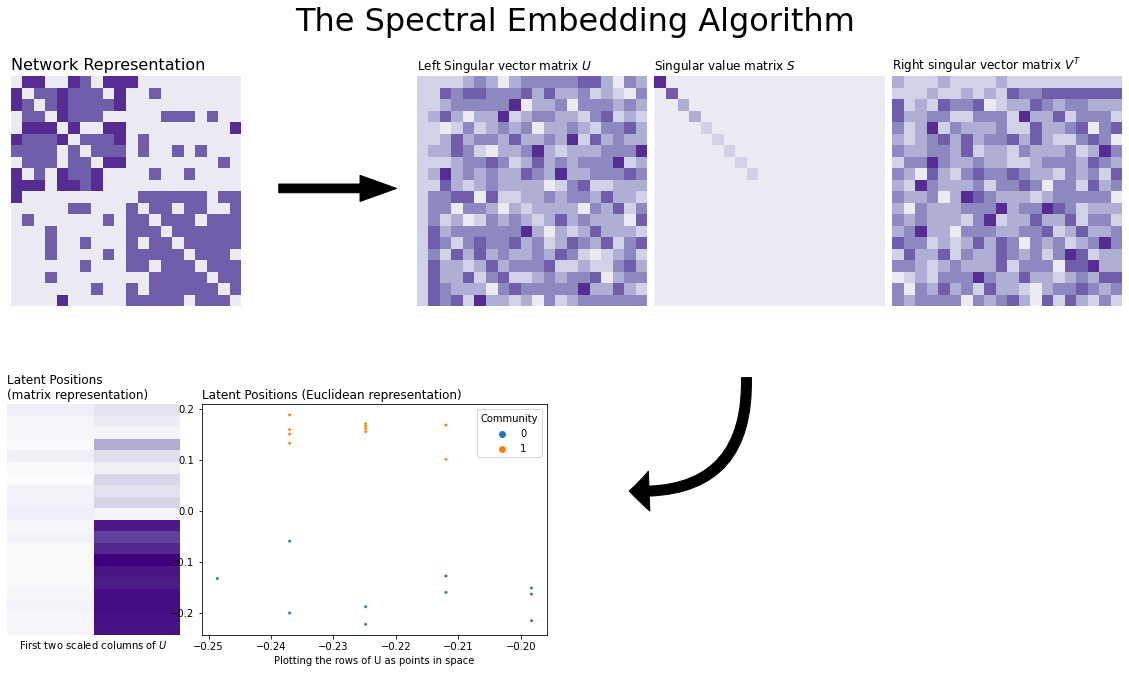

In [204]:
from graspologic.simulations import sbm
from graphbook_code import heatmap, cmaps, plot_latents
from graspologic.utils import to_laplacian
from scipy.linalg import svd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def rm_ticks(ax, x=False, y=False, **kwargs):
    if x is not None:
        ax.axes.xaxis.set_visible(x)
    if y is not None:
        ax.axes.yaxis.set_visible(y)
    sns.despine(ax=ax, **kwargs)

# Make network
B = np.array([[0.8, 0.1], 
              [0.1, 0.8]])
n = [10, 10]
A, labels = sbm(n=n, p=B, return_labels=True)
L = to_laplacian(A)
U, E, Ut = svd(L)
n_components = 2
Uc = U[:, :n_components]
Ec = E[:n_components]
latents = Uc @ np.diag(Ec)
    
fig = plt.figure();

ax = fig.add_axes([.06, -.06, .8, .8]) 
ax = heatmap(L, ax=ax, cbar=False)
ax.set_title("Network Representation", loc="left", fontsize=16)


# add arrow
arrow_ax = fig.add_axes([.8, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add joint matrix
ax = fig.add_axes([1, -.02*3, .8, .8])
ax = heatmap(U, ax=ax, cbar=False)
ax.set_title("Left Singular vector matrix $U$", loc="left")

ax = fig.add_axes([1.55, -.06, .8, .8])
ax = heatmap(np.diag(E), ax=ax, cbar=False)
ax.set_title("Singular value matrix $S$", loc="left")

ax = fig.add_axes([2.1, -.06, .8, .8])
ax = heatmap(Ut, ax=ax, cbar=False)
ax.set_title("Right singular vector matrix $V^T$", loc="left")
    
# add second arrow
arrow_ax = fig.add_axes([1.5, -1.2, 1.2, 1])
rm_ticks(arrow_ax, left=True, bottom=True)
style = "Simple, tail_width=10, head_width=40, head_length=20"
kw = dict(arrowstyle=style, color="k", alpha=1)
text_arrow = patches.FancyArrowPatch((0.33, .9), (.1, .5), connectionstyle="arc3, rad=-.55", **kw)
arrow_ax.add_patch(text_arrow)


# Embedding
ax = fig.add_axes([.185, -1.2, .4, .8])
cmap = cmaps["sequential"]
ax = sns.heatmap(latents, cmap=cmap, 
            ax=ax, cbar=False, xticklabels=False, yticklabels=False)
ax.set_title("Latent Positions \n(matrix representation)", loc="left")
ax.set_xlabel("First two scaled columns of $U$")

ax = fig.add_axes([.185+.45, -1.2, .8, .8])
plot_latents(latents, ax=ax, labels=labels)
ax.set_title("Latent Positions (Euclidean representation)", loc="left")
ax.set_xlabel("Plotting the rows of U as points in space")

fig.suptitle("The Spectral Embedding Algorithm", fontsize=32, x=1.5);

```{admonition} The Spectral Embedding Algorithm
1. Take a network's adjacency matrix. Optionally take its Laplacian as a network representation.
2. Decompose it into a a singular vector matrix, a singular value matrix, and the singular vector matrix's transpose.
3. Remove every column of the singular vector matrix except for the first $k$ vectors, corresponding to the $k$ largest singular values.
4. Scale the $k$ remaining columns by their corresponding singular values to create the embedding.
5. The rows of this embedding matrix are the locations in Euclidean space for the nodes of the network (called the latent positions). The embedding matrix is an estimate of the latent position matrix (which we talked about in the 'why embed networks' section)
```

We need to dive into a few specifics to understand spectral embedding better. We need to figure out how to find our network's singular vectors, for instance, and we also need to understand why those singular vectors can be used to form a representation of our network. To do this, we'll explore a few concepts from linear algebra like matrix rank, and we'll see how understanding these concepts connects to understanding spectral embedding.

Let's scale down and make a simple network, with only six nodes. We'll take its Laplacian just to show what that optional step looks like, and then we'll find its singular vectors with a technique we'll explore called Singular Value Decomposition. Then, we'll explore why we can use the first $k$ singular values and vectors to find an embedding. Let's start with creating the simple network.

## A Simple Network

Say we have the simple network below. There are six nodes total, numbered 0 through 5, and there are two distinct connected groups (called "connected components" in network theory land). Nodes 0 through 2 are all connected to each other, and nodes 3 through 5 are also all connected to each other. 

In [205]:
from itertools import combinations
import numpy as np

def add_edge(A, edge: tuple):
    """
    Add an edge to an undirected graph.
    """
    i, j = edge
    A[i, j] = 1
    A[j, i] = 1
    return A

A = np.zeros((6, 6))

for edge in combinations([0, 1, 2], 2):
    add_edge(A, edge)
    
for edge in combinations([3, 4, 5], 2):
    add_edge(A, edge)

You can see the adjacency matrix and network below. Notice that there are two distrinct blocks in the adjacency matrix: in its upper-left, you can see the edges between the first three nodes, and in the bottom right, you can see the edges between the second three nodes.

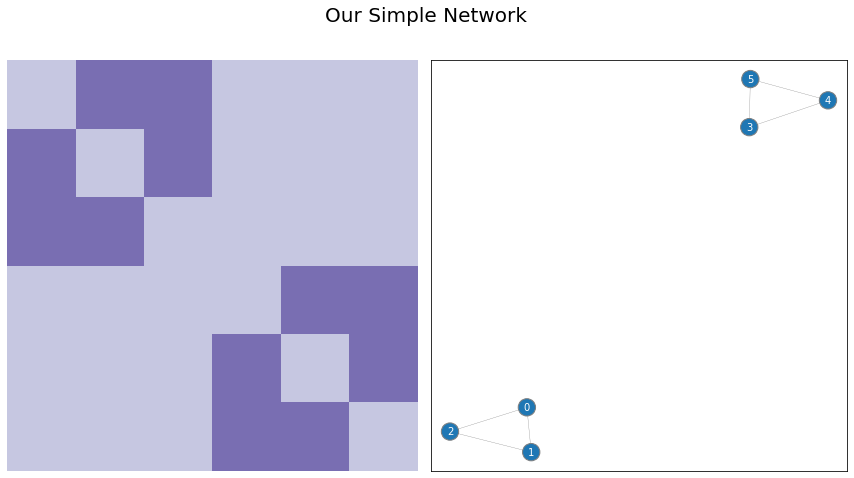

In [206]:
from graphbook_code import draw_multiplot
import networkx as nx

draw_multiplot(A, pos=nx.kamada_kawai_layout, title="Our Simple Network");

## The Laplacian Matrix

With spectral embedding, we'll either find the singular vectors of the Laplacian or the singular vectors of the Adjacency Matrix itself (For undirected Laplacians, the singular vectors are the same thing as the eigenvectors). Since we already have the adjacency matrix, let's take the Laplacian just to see what that looks like.

Remember from chapter four that there are a few different types of Laplacian matrices. By default, for undirected networks, Graspologic uses the normalized Laplacian $L = D^{-1/2} A D^{-1/2}$, where $D$ is the degree matrix. Remember that the degree matrix has the degree, or number of edges, of each node along the diagonals. Variations on the normalized Laplacian are generally what we use in practice, but for simplicity and illustration, we'll just use the basic, cookie-cutter version of the Laplacian $L = D - A$.

Here's the degree matrix $D$.

In [207]:
# Build the degree matrix D
degrees = np.count_nonzero(A, axis=0)
D = np.diag(degrees)
D

array([[2, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0],
       [0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 2]])

And here's the Laplacian matrix, written out in full.

In [208]:
# Build the Laplacian matrix L
L = D-A
L

array([[ 2., -1., -1.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.,  0.],
       [-1., -1.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  2., -1., -1.],
       [ 0.,  0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0., -1., -1.,  2.]])

Below, you can see these matrices visually.

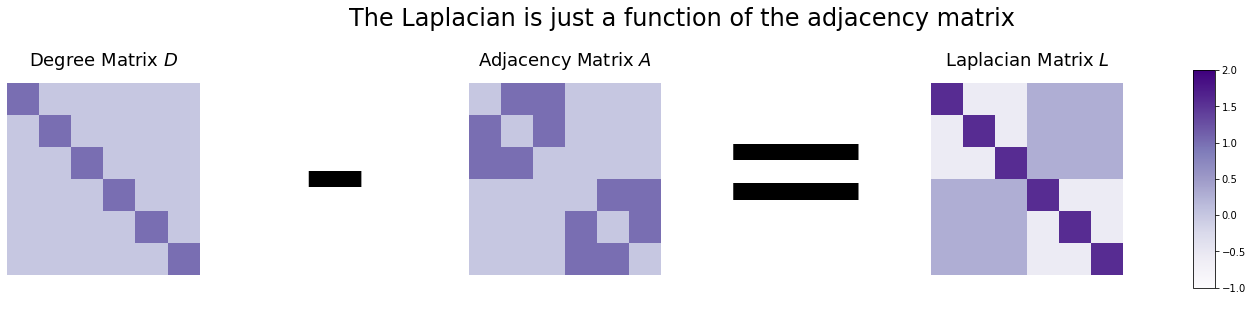

In [209]:
from graphbook_code import heatmap
import seaborn as sns
from matplotlib.colors import Normalize
from graphbook_code import GraphColormap
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# First axis (Degree)
heatmap(D, ax=axs[0], cbar=False, title="Degree Matrix $D$")

# Second axis (-)
axs[1].text(x=.5, y=.5, s="-", fontsize=200, 
            va='center', ha='center')
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)
sns.despine(ax=axs[1], left=True, bottom=True)

# Third axis (Adjacency matrix)
heatmap(A, ax=axs[2], cbar=False, title="Adjacency Matrix $A$")

# Third axis (=)
axs[3].text(x=.5, y=.5, s="=", fontsize=200,
            va='center', ha='center')
axs[3].get_xaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)
sns.despine(ax=axs[3], left=True, bottom=True)

# Fourth axis
heatmap(L, ax=axs[4], cbar=False, title="Laplacian Matrix $L$")

# Colorbar
vmin, vmax = np.array(L).min(), np.array(L).max()
norm = Normalize(vmin=vmin, vmax=vmax)
im = cm.ScalarMappable(cmap=GraphColormap("sequential").color, norm=norm)
fig.colorbar(im, ax=axs, shrink=0.8, aspect=10);

fig.suptitle("The Laplacian is just a function of the adjacency matrix", fontsize=24);

## Finding Singular Vectors With Singular Value Decomposition

Now that we have a Laplacian matrix, we'll want to find its singular vectors. To do this, we'll need to use a technique called *Singular Value Decomposition*, or SVD. 

SVD is a way to break a single matrix apart (also known as factorizing) into three distinct new matrices -- In our case, the matrix will be the Laplacian we just built. These three new matrices correspond to the singular vectors and singular values of the original matrix: the algorithm will collect all of the singular vectors as columns of one matrix, and the singular values as the diagonals of another matrix.


```{admonition} Singular-Value Decomposition (SVD) of a real, square matrix
The singular value decomposition of a matrix $X$ whose entries are all real with $n$ rows and $n$ columns is the set of matrices $U, \Sigma$, and $V$, where:
\begin{align*}
    P &= U\Sigma V^\top
\end{align*}
where $U$, $\Sigma$, and $V$ have some special properties:
1. The left singular vectors: the columns $\vec u_i$ of $U$ are called the left singular vectors of $X$. If $X$ has $n$ rows and $n$ columns, there will be $n$ left singular vectors. This matrix looks like this:
\begin{align*}
    U &= \begin{bmatrix}
        \vec u_1 & ... & \vec u_n
    \end{bmatrix}
\end{align*}
$U$ is also orthonormal, which we will learn more about [later in this Chapter](#link?).

2. The singular values: the matrix $\Sigma$ is a diagonal matrix, which means that it has entries along the diagonal and all the other entries are just *zero*. There will be $n$ total of these. This matrix looks something like this:
\begin{align*}
    \Sigma &= \begin{bmatrix}
        \sigma_1 & 0 & ... & 0 \\
        0 & \sigma_2 & \ddots & \vdots \\
        \vdots & \ddots & \ddots & 0 \\
        0 & ... & 0 & \sigma_n
    \end{bmatrix}
\end{align*}
The special property is that by definition, the singular values are *descending*, in that $\sigma_1 \geq \sigma_2$, $\sigma_2 \geq \sigma_3$, so on and so forth to $\sigma_n$.

3. The right singular vectors: the columns $\vec v_i$ of $V$ are called the right singular vectors of $X$. If $X$ has $n$ rows and $n$ columns, there will be $n$ right singular vectors. This matrix looks like this:
\begin{align*}
V &= \begin{bmatrix}
    \vec v_1 & ... & \vec v_n
\end{bmatrix}
$V$ is also orthonormal.
\end{align*}
```

#### Applying the SVD to the Laplacian

To show this, we'll take the SVD of our Laplacian matrix $L$, and then express $L$ as the matrix product:

In [210]:
U, s, Vt = np.linalg.svd(L)

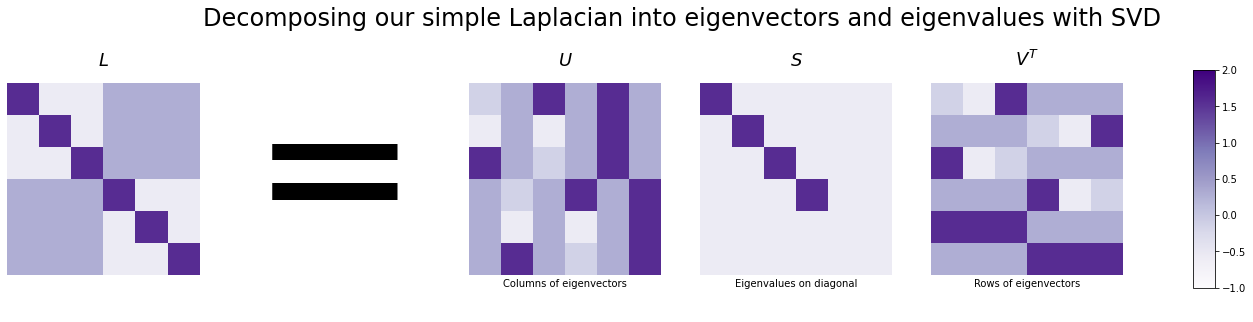

In [211]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# First axis (Laplacian)
heatmap(L, ax=axs[0], cbar=False, title="$L$")

# Second axis (=)
axs[1].text(x=.5, y=.5, s="=", fontsize=200, 
            va='center', ha='center')
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)
sns.despine(ax=axs[1], left=True, bottom=True)

# Third axis (U)
U_ax = heatmap(U, ax=axs[2], cbar=False, title="$U$")
U_ax.set_xlabel("Columns of eigenvectors")

# Third axis (S)
E_ax = heatmap(np.diag(S), ax=axs[3], cbar=False, title="$S$")
E_ax.set_xlabel("Eigenvalues on diagonal")

# Fourth axis (V^T)
Ut_ax = heatmap(Vt, ax=axs[4], cbar=False, title="$V^T$")
Ut_ax.set_xlabel("Rows of eigenvectors")

# Colorbar
vmin, vmax = np.array(L).min(), np.array(L).max()
norm = Normalize(vmin=vmin, vmax=vmax)
im = cm.ScalarMappable(cmap=GraphColormap("sequential").color, norm=norm)
fig.colorbar(im, ax=axs, shrink=0.8, aspect=10);

fig.suptitle("Decomposing our simple Laplacian into eigenvectors and eigenvalues with SVD", fontsize=24);

## The SVD as a sum of rank-1 matrices

This expression is a little bit complicated, so we will simplify it down a little bit here: as it turns out, this "complicated" looking matrix multiplication is actually pretty straightforward because $\Sigma$ is diagonal. We can write this equation down like this, which is much more understandable:

\begin{align*}
    X &= \sum_{i = 1}^n \sigma_i \vec u_i \vec v_i^\top = \sum_{i = 1}^n \sigma_i\begin{bmatrix}
        \uparrow \\ \vec u_i \\ \downarrow
    \end{bmatrix}\begin{bmatrix}
        \leftarrow & \vec v_i^\top & \rightarrow
    \end{bmatrix}
\end{align*}

Let's try to interpret what this intimitating sum really is saying to us. To start with, for each term, we have the left singular vector, $\vec u_i$. By matrix multiplication, taking the product of $\vec u_i$ with $\vec v_i^\top$ gives us this:
\begin{align*}
    \vec u_i \vec v_i^\top &= \begin{bmatrix}
    \uparrow &  & \uparrow \\
    v_{i1}\vec u_i & ... & v_{in}\vec u_i \\
    \downarrow &  & \downarrow
    \end{bmatrix}
\end{align*}
So basically, we have a matrix with $n$ columns, all of which are multiples of the vector $\vec u_i$. What multiple? Well, that is what $\vec v_i$ tells us: the "amount" of $\vec u_i$ in a particular column $j$ is indicated by $v_{ij}$. This gives us a matrix, $\vec u_i\vec v_i^\top$, which *also* has $n$ rows and $n$ columns, where every row is a multiple of $\vec u_i$. This introduces us to our next important property: *matrix rank*.

```{admonition} Matrix rank
The *rank* of a matrix is a description of just how complicated the matrix is. A matrix is **low rank** if any of its rows (or equivalently, its columns) are linear combinations of other rows (or columns). What this means is that if we can take rows or columns from the matrix, and add or multiply them together to get other rows or columns from the matrix, the matrix is low rank. This means that information contained in the matrix is redundant, in that we could obtain it by just adding or subtracting other information already contained in the matrix if we had instructions as to how to properly combine that information.
```

Since every column of $\vec u_i \vec v_i^\top$ is a multiple of $\vec u_i$, it's pretty clear that the resulting matrix $\vec u_i \vec v_i^\top$ is low rank. Finally, we just take this $n$ row and $n$ column matrix, and we multiply the whole thing by $\sigma_i$. So as it turns out, $X$ is equal to a weighted sum of rank-$1$ matrices, where the weights are all given to us by the singular values:
\begin{align*}X &= \sum_{i = 1}^n \sigma_i \vec u_i \vec v_i^\top = \sigma_1\begin{bmatrix}
        \uparrow \\ \vec u_1 \\ \downarrow
    \end{bmatrix}\begin{bmatrix}
        \leftarrow & \vec v_1^\top & \rightarrow
    \end{bmatrix} + ... + \sigma_n\begin{bmatrix}
        \uparrow \\ \vec u_n \\ \downarrow
    \end{bmatrix}\begin{bmatrix}
        \leftarrow & \vec v_n^\top & \rightarrow
    \end{bmatrix}
\end{align*}

### The Laplacian as a sum of rank-$1$ matrices
Let's express this operation using the Laplacian:

In [212]:
n_nodes = L.shape[0]
low_rank_matrices = []
for i in range(0, n_nodes):
    low_rank_matrices.append(s[i]*np.array(U[:,[i]]) @ np.array(Vt[[i],:]))
Lsum = np.sum(low_rank_matrices, axis=0)

AttributeError: 'NoneType' object has no attribute 'get_subplotspec'

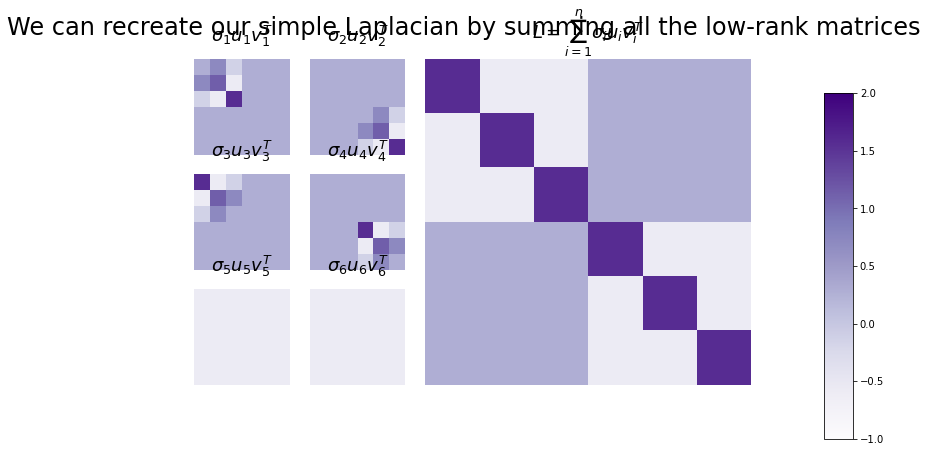

In [213]:
from matplotlib.gridspec import GridSpec
import warnings

fig = plt.figure(figsize=(10, 6))
gs = GridSpec(3, 5)
ax_laplacian = fig.add_subplot(gs[:, 2:])

# Plot low-rank matrices
i = 0
for row in range(3):
    for col in range(2):
        ax = fig.add_subplot(gs[row, col])
        title = f"$\sigma_{i+1} u_{i+1} v_{i+1}^T$"
        heatmap(low_rank_matrices[i], ax=ax, cbar=False, title=title)
        i += 1
        
# Plot Laplacian
heatmap(Lsum, ax=ax_laplacian, cbar=False, title="$L = \sum_{i = 1}^n \sigma_i u_i v_i^T$")

# # Colorbar
cax = fig.add_axes([1, 0, .04, .8])
vmin, vmax = np.array(Lsum).min(), np.array(Lsum).max()
norm = Normalize(vmin=vmin, vmax=vmax)
im = cm.ScalarMappable(cmap=GraphColormap("sequential").color, norm=norm)
fig.colorbar(im, cax=cax, use_gridspec=False);


fig.suptitle("We can recreate our simple Laplacian by summing all the low-rank matrices", fontsize=24)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.tight_layout();

## Critical Properties of the SVD

We're also going to repeatedly make use of a property of the Singular Value Decomposition, or `svd`, that will be very handy for this section and the next section:

```{admonition} Left/Right Singular Vector equivalences
1. If the matrix $X$ is positive (its entries all exceed zero), square, and symmetric, $K$ non-zero left singular vectors and right singular vectors are *equal*. This means that for a matrix $X$ which satisfies the criterion explained, then for any index $i$ where $\sigma_i > 0$, $u_i$ and $v_i$ are the same. 

This condition can be met, for instance, if $X$ is a probability matrix for an undirected network. Network probability matrices are always square, with $n$ rows and $n$ columns for each of the $n$ nodes. Because the network is undirected, the matrix is symmetric, because the probability that node $i$ is connected to node $j$ must equal the probability that node $j$ is connected to node $i$. 

2. If the matrix $X$ is symmetric and has real, positive singular values, then the left and right singular vectors are *all* equal. 

This condition can be met, for instance, by a network Laplacian. The reason the Laplacian meets this criterion exceeds the scope of this book, but we encourage you to check out a Linear Algebra book for further details.
```

For more technical and generalized details on how SVD works, or for explicit proofs, we would recommend a Linear Algebra textbook [Trefethan, LADR]. We'll look at the SVD with a bit more detail here in the specific case where we start with a matrix which is square, symmetric, and has real eigenvalues.

### The Laplacian left/right singular vector equivalence

Next, we'll see that the left and right singular vectors are equivalent for the Laplacian. We take a look at $U$ and $V$, as well as their difference. We will quantify the difference between $U$ and $V$ using the *Frobenius norm* of the difference between them. This quantity, abbreviated $||U - V||_F$, has a value greater than $0$ if the two matrices have any entries not in common:

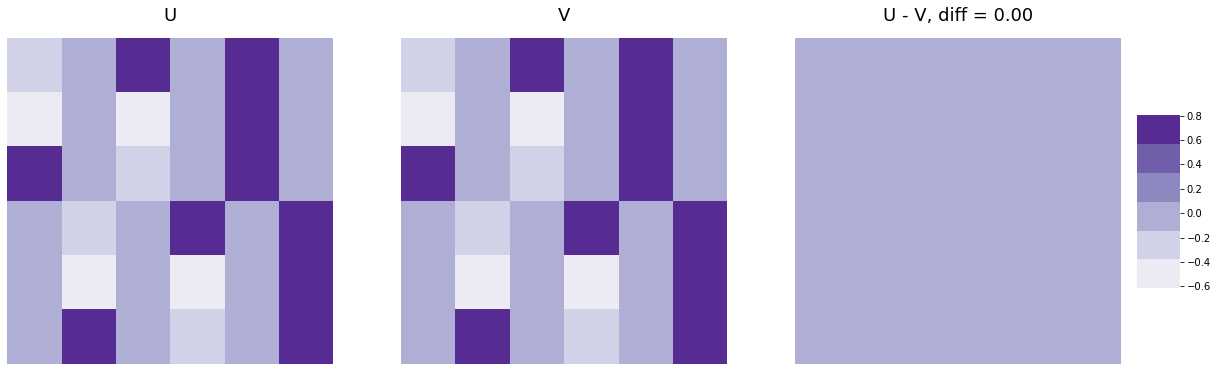

In [237]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

vmin, vmax = np.min(np.hstack([U, Vt])), np.max(np.hstack([U, Vt]))
diff = np.linalg.norm(U - Vt.transpose())

cbar_ax = fig.add_axes([.91, .3, .03, .4])

mtxs = [U, Vt.transpose(), U - Vt.transpose()]
title = ["U", "V", "U - V, diff = {:.2f}".format(diff)]
for i, ax in enumerate(axs.flat):
    heatmap(mtxs[i], cbar=i == 0, title=title[i], vmin=vmin, vmax=vmax, ax=ax,
           cbar_ax = None if i else cbar_ax)

### We can approximate our simple Laplacian by only summing a few of the low-rank matrices

When you sum the first few of these low-rank $\sigma_i u_i u_i^T$, you can *approximate* your original matrix.

This tells us something interesting about Spectral Embedding: the information in the first few eigenvectors of a high rank matrix lets us find a more simple approximation to it. You can take a matrix that's extremely complicated (high-rank) and project it down to something which is much less complicated (low-rank).

Look below. In each plot, we're summing more and more of these low-rank matrices. By the time we get to the fourth sum, we've totally recreated the original Laplacian.

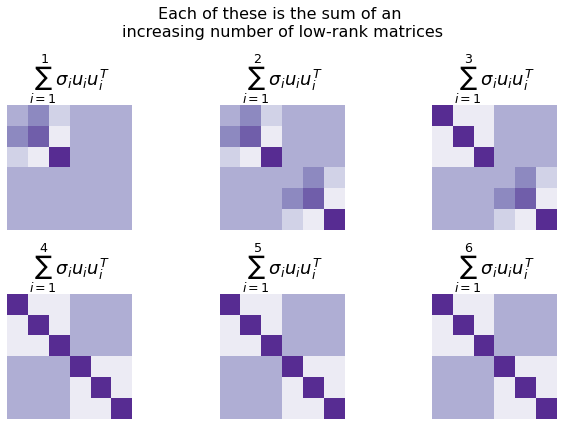

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(9,6))

current = np.zeros(L.shape)
for i, ax in enumerate(axs.flat):
    new = low_rank_matrices[i]
    current += new
    heatmap(current, ax=ax, cbar=False, 
            title=f"$\sum_{{i = 1}}^{i+1} \sigma_i u_i u_i^T$")
    
fig.suptitle("Each of these is the sum of an \nincreasing number of low-rank matrices", fontsize=16)
plt.tight_layout()

### Approximating becomes extremely useful when we have a bigger (now regularized) Laplacian

This becomes even more useful when we have huge networks with thousands of nodes, but only a few communities. It turns out, especially in this situation, we can usually sum a very small number of low-rank matrices and get to an excellent approximation for our network that uses much less information.

Take the network below, for example. It's generated from a Stochastic Block Model with 1000 nodes total (500 in one community, 500 in another). We took its normalized Laplacian (remember that this means $L = D^{-1/2} A D^{-1/2}$), decomposed it, and summed the first two low-rank matrices that we generated from the eigenvector columns.

The result is not exact, but it looks pretty close. And we only needed the information from the first two singular vectors instead of all of the information in our full $n \times n$ matrix! 

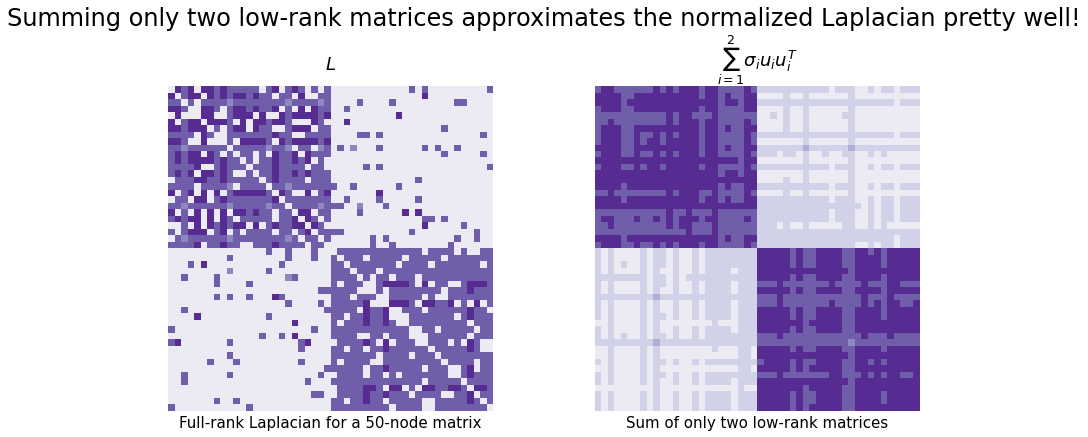

In [12]:
from graspologic.simulations import sbm
from graspologic.utils import to_laplacian

# Make network
B = np.array([[0.8, 0.1], 
              [0.1, 0.8]])
n = [25, 25]
A2, labels2 = sbm(n=n, p=B, return_labels=True)

# Form new laplacian
L2 = to_laplacian(A2)

# decompose
k = 2
U2, E2, Ut2 = svd(L2)

k_matrices = U2[:, k]
low_rank_approximation = U2[:,0:k] @ (np.diag(E2[0:k]) @ Ut2[0:k, :])


# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
l2_hm = heatmap(L2, ax=axs[0], cbar=False, title="$L$")
l2approx_hm = heatmap(low_rank_approximation, ax=axs[1], cbar=False, title="$\sum_{{i = 1}}^{2} \sigma_i u_i u_i^T$")

l2_hm.set_xlabel("Full-rank Laplacian for a 50-node matrix", fontdict={'size': 15})
l2approx_hm.set_xlabel("Sum of only two low-rank matrices", fontdict={'size': 15});

fig.suptitle("Summing only two low-rank matrices approximates the normalized Laplacian pretty well!", fontsize=24)

plt.tight_layout()

This is where a lot of the power of an SVD comes from: you can approximate extremely complicated (high-rank) matrices with extremely simple (low-rank) matrices.

## How This Matrix Rank Stuff Helps Us Understand Spectral Embedding

Remember the actual spectral embedding algorithm: we take a network, decompose it with Singular Value Decomposition into its singular vectors and values, and then cut out everything but the top $k$ singular vector/value pairs. Once we scale the columns of singular vectors by their corresponding values, we have our embedding. That embedding is called the latent position matrix, and the locations in space for each of our nodes are called the latent positions.

Let's go back to our original, small (six-node) network and make an estimate of the latent position matrix from it. We'll embed down to three dimensions.

In [13]:
k = 3
U_cut = U[:, :k]
E_cut = E[:k]

latents_small = U_cut @ np.diag(E_cut)

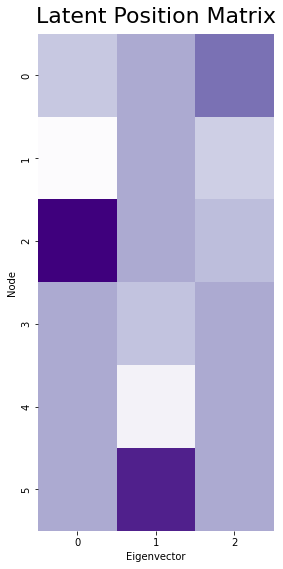

In [14]:
fig, ax = plt.subplots(figsize=(4, 8))
cmap = cmaps["sequential"]
ax = sns.heatmap(latents_small, cmap=cmap, ax=ax, cbar=False, 
                 xticklabels=1, yticklabels=1)
ax.set_xlabel("Eigenvector")
ax.set_ylabel("Node")

ax.set_title("Latent Position Matrix", fontsize=22, y=1.01)
plt.tight_layout();

How does what we just talked about help us understand spectral embedding?

Well, each column of the latent position matrix is the $i^{th}$ eigenvector scaled by the $i^{th}$ eigenvalue: $\sigma_i \vec{u_i}$. If we right-multiplied one of those columns by its unscaled transpose $\vec{u_i}^\top$, we'd have one of our rank one matrices. This means that you can think of our rank-one matrices as essentially just fancy versions of the columns of a latent position matrix (our embedding). They contain all the same information - they're just matrices instead of vectors!

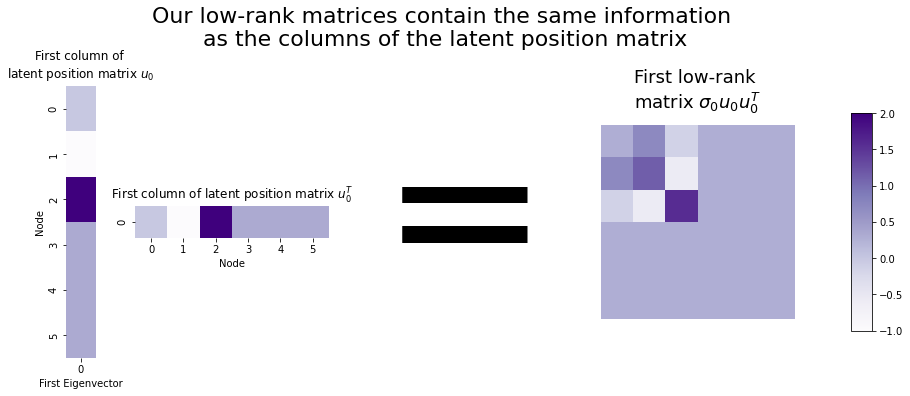

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# First axis (Degree)
first_col = E[0] * latents_small[:, 0, None]
first_mat = first_col @ first_col.T
ax = sns.heatmap(first_col, cmap=cmap, ax=axs[0], cbar=False, 
                 xticklabels=1, yticklabels=1)
ax.set_aspect(1.5)
ax.set_xlabel("First Eigenvector")
ax.set_ylabel("Node")
ax.set_title("First column of \nlatent position matrix $u_0$", fontsize=12, y=1.01)

# Third axis (Adjacency matrix)
ax = sns.heatmap(first_col.T, cmap=cmap, ax=axs[1], cbar=False, 
                 xticklabels=1, yticklabels=1, square=False)
ax.set_aspect(1)
ax.set_xlabel("Node")
ax.set_title("First column of latent position matrix $u_0^T$", fontsize=12, y=1.01)

# Third axis (=)
axs[2].text(x=.5, y=.5, s="=", fontsize=200,
            va='center', ha='center')
axs[2].get_xaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
sns.despine(ax=axs[2], left=True, bottom=True)

# Fourth axis
heatmap(first_mat, ax=axs[3], cbar=False, title="First low-rank \nmatrix $\sigma_0 u_0 u_0^T$")

# Colorbar
vmin, vmax = np.array(L).min(), np.array(L).max()
norm = Normalize(vmin=vmin, vmax=vmax)
im = cm.ScalarMappable(cmap=GraphColormap("sequential").color, norm=norm)
fig.colorbar(im, ax=axs, shrink=0.8, aspect=10);

fig.suptitle("Our low-rank matrices contain the same information\n as the columns of the latent position matrix", fontsize=22, y=1.1);

In fact, you can express the sum we did earlier - our lower-rank estimation of L - with just our latent position matrix! Remember that $U_k$ is the first $k$ eigenvectors of our Laplacian, and $S_k$ is the diagonal matrix with the first $k$ eigenvalues (and that we named them $\sigma_1$ through $\sigma_k$).


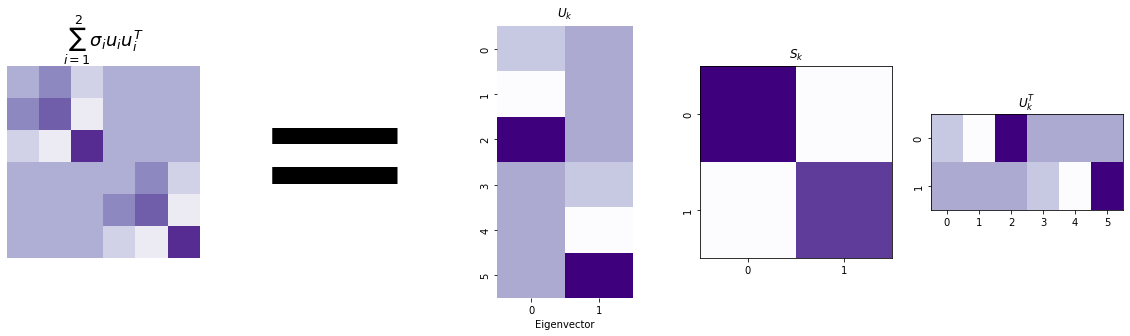

In [16]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

# First axis (sum matrix)
current = np.zeros(L.shape)
for i in range(2):
    new = low_rank_matrices[i]
    current += new
    
heatmap(current, ax=axs[0], cbar=False, title="$\sum_{i=1}^2 \sigma_i u_i u_i^T$")

# Second axis (=)
axs[1].text(x=.5, y=.5, s="=", fontsize=200,
            va='center', ha='center')
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)
sns.despine(ax=axs[1], left=True, bottom=True)

# Third axis (Uk)
k = 2
Uk = U[:, :k]
Ek = np.diag(E)[:k, :k]
ax = sns.heatmap(Uk, cmap=cmap, ax=axs[2], cbar=False, 
                 xticklabels=1, yticklabels=1)
ax.set_box_aspect(2)
ax.set_xlabel("Eigenvector")
ax.set_title("$U_k$", fontsize=12, y=1.01)


# Ek
ax = sns.heatmap(Ek, cmap=cmap, ax=axs[3], cbar=False, 
                 xticklabels=1, yticklabels=1, square=True)
ax.set_title("$S_k$", fontsize=12, y=1.01)
sns.despine(bottom=False, top=False, right=False, left=False, ax=ax)

# Uk^T
# TODO: make this the same size as Uk, just rotated (currently too small)
# Will probably involve revamping all this code to make subplots differently,
# because the reason it's that size is that the dimensions are constrained by the `plt.subplots` call.
transform = Affine2D().rotate_deg(90)
axs[4].set_transform(transform)
ax = sns.heatmap(Uk.T, cmap=cmap, ax=axs[4], cbar=False, 
                 xticklabels=1, yticklabels=1)
ax.set_box_aspect(.5)
ax.set_title("$U_k^T$", fontsize=12, y=1.01)
sns.despine(bottom=False, top=False, right=False, left=False, ax=ax)

This helps gives an intuition for why our latent position matrix gives a representation of our network. You can take columns of it, turn those columns into matrices, and sum those matrices, and then estimate the Laplacian for the network. That means the columns of our embedding network contain all of the information necessary to estimate the network!

## Figuring Out How Many Dimensions To Embed Your Network Into

One thing we haven't addressed is how to figure out how many dimensions to embed down to. We've generally been embedding into two dimensions throughout this chapter (mainly because it's easier to visualize), but you can embed into as many dimensions as you want.

If you don't have any prior information about the "true" dimensionality of your latent positions, by default you'd just be stuck guessing. Fortunately, there are some rules-of-thumb to make your guess better, and some methods people have developed to make fairly decent guesses automatically.

The most common way to pick the number of embedding dimensions is with something called a scree plot. Essentially, the intuition is this: the top singular vectors of an adjacency matrix contain the most useful information about your network, and as the singular vectors have smaller and smaller singular values, they contain less important and so are less important (this is why we're allowed to cut out the smallest $n-k$ singular vectors in the spectral embedding algorithm).

The scree plot just plots the singular values by their indices: the first (biggest) singular value is in the beginning, and the last (smallest) singular value is at the end.

You can see the scree plot for the Laplacian we made earlier below. We're only plotting the first ten singular values for demonstration purposes.

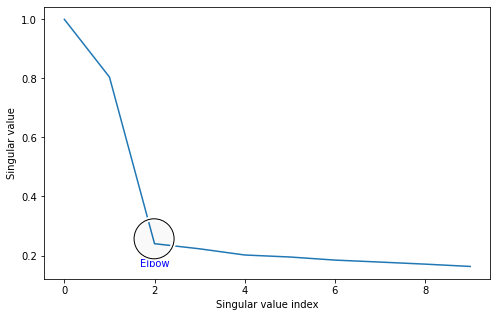

In [17]:
# from graspologic.plot import screeplot
from matplotlib.patches import Circle
from matplotlib.patheffects import withStroke
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredDrawingArea
from scipy.linalg import svdvals

fig, ax = plt.subplots(figsize=(8, 5))

# eigval plot
D = svdvals(L2)
ax.plot(D[:10])
ax.set_xlabel("Singular value index")
ax.set_ylabel("Singular value")

# plot circle
x, y = .15, .15
radius = .15
ada = AnchoredDrawingArea(150, 150, 0, 0, loc='lower left', pad=0., frameon=False)
circle = Circle((105, 35), 20, clip_on=False, zorder=10, linewidth=1,
                edgecolor='black', facecolor=(0, 0, 0, .0125),
                path_effects=[withStroke(linewidth=5, foreground='w')])
ada.da.add_artist(circle)
ax.add_artist(ada)

# add text
def text(x, y, text):
    ax.text(x, y, text, backgroundcolor="white",
            ha='center', va='top', color='blue')
    
text(2, .19, "Elbow")

You'll notice that there's a marked area called the "elbow". This is an area where singular values stop changing in magnitude as much when they get smaller: before the elbow, singular values change rapidly, and after the elbow, singular values barely change at all. (It's called an elbow because the plot kind of looks like an arm, viewed from the side!)

The location of this elbow gives you a rough indication for how many "true" dimensions your latent positions have. The singular values after the elbow are quite close to each other and have singular vectors which are largely noise, and don't tell you very much about your data. It looks from the scree plot that we should be embedding down to two dimensions, and that adding more dimensions would probably just mean adding noise to our embedding.

One drawback to this method is that a lot of the time, the elbow location is pretty subjective - real data will rarely have a nice, pretty elbow like the one you see above. The advantage is that it still generally works pretty well; embedding into a few more dimensions than you need isn't too bad, since you'll only have a few noies dimensions and there still may be *some* signal there.

In any case, Graspologic automates the process of finding an elbow using a popular method developed in 2006 by Mu Zhu and Ali Ghodsi at the University of Waterloo. We won't get into the specifics of how it works here, but you can usually find fairly good elbows automatically.

## Using Graspologic to embed networks

It's pretty straightforward to use graspologic's API to embed a network. The setup works like an SKlearn class: you instantiate an AdjacencySpectralEmbed class, and then you use it to transform data. You set the number of dimensions to embed to (the number of eigenvector columns to keep!) with `n_components`, or alternatively, let this value be selected automatically with elbow selection. We'll show how to use Adjacency Spectral Embedding where we know the right number of dimensions to use is $2$, and Laplacian Spectral Embedding where we let elbow selection pick for us.

### Adjacency Spectral Embedding

In [176]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

# Generate a network from an SBM
B = np.array([[0.8, 0.1], 
              [0.1, 0.8]])
n = [25, 25]
A, labels = sbm(n=n, p=B, return_labels=True)

# Instantiate an ASE model and find the embedding
ase = ASE(n_components=2)
embedding = ase.fit_transform(A)

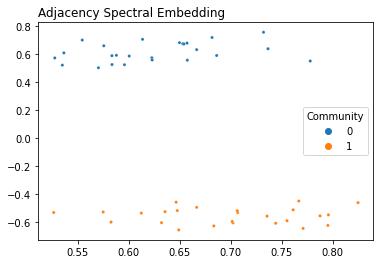

In [177]:
plot_latents(embedding, labels=labels, title="Adjacency Spectral Embedding");

### Laplacian Spectral Embedding

Here, we'll let elbow selection do the work for us, by not selecting any number of latent dimensions ahead of time.

In [185]:
from graspologic.embed import LaplacianSpectralEmbed as LSE

embedding = LSE().fit_transform(A)

Estimated number of latent dimensions: 3


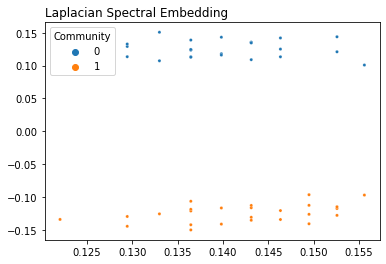

In [186]:
print("Estimated number of latent dimensions: {:d}".format(lse.n_components_))

plot_latents(embedding, labels=labels, title="Laplacian Spectral Embedding");

## When should you use ASE and when should you use LSE?

Throughout this article, we've primarily used LSE, since Laplacians have some nice properties (such as having singular values being the same as eigenvalues) that make stuff like SVD easier to explain. However, you can embed the same network with either ASE or LSE, and you'll get two different (but equally true) embeddings.

Since both embeddings will give you a reasonable clustering, how are they different? When should you use one compared to the other?

Well, it turns out that LSE and ASE capture different notions of "clustering". Carey Priebe and collaborators at Johns Hopkins University investigated this recently - in 2018 - and discovered that LSE lets you capture "affinity" structure, whereas ASE lets you capture "core-periphery" structure (their paper is called "On a two-truths phenomenon in spectral graph clustering" - it's an interesting read for the curious). The difference between the two types of structure is shown in the image below.


```{figure} ../../Images/two-truths.jpeg
---
height: 400px
name: two-truths
---
Affinity vs. Core-periphery Structure 
```

The "affinity" structure - the one that LSE is good at finding - means that you have two groups of nodes which are well-connected within the groups, and aren't very connected with each other. Think of a friend network in two schools, where people within the same school are much more likely to be friends than people in different schools. This is a type of structure we've seen a lot in this book in our Stochastic Block Model examples. If you think the communities in your data look like this, you should apply LSE to your network.

The name "core-periphery" is a good description for this type of structure (which ASE is good at finding). In this notion of clustering, you have a core group of well-connected nodes surrounded by a bunch of "outlier" nodes which just don't have too many edges with anything in general. Think of a core of popular, well-liked, and charismatic kids at a high school, with a periphery of loners or people who prefer not to socialize as much.